# Домашнее задание 2 (Линейная регрессия и KNN)

В каждом пункте от вас потребуется дописать код, необходимый для реализации задания, а так же ответить на ряд вопросов, проанализировав полученные результаты. Просьба отвечать на вопросы развёрнуто, аппелируя к полученным значениям или графикам, ответы вписывать в отдельную ячейку, выбрав для неё тип "Markdown". От полноты и качества ответов будет во многом зависеть ваша итоговая оценка.

Задание выполняется самостоятельно, плагиат будет стандартно наказываться лишением всех баллов за задание.

- Максимальная оценка за задание: 10 баллов.
- Дата выдачи: 28.2.2018
- Срок сдачи: 23:59 13.3.2018

In [114]:
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split



Для реализации задания, а так же ответить на ряд вопросов, проанализировав полученные результаты. Просьба отвечать на вопросы развёрнуто, аппелируя к полученным значениям или графикам, ответы вписывать в отдельную ячейку, выбрав для неё тип "Markdown". От полноты и качества ответов будет во многом зависеть ваша итоговая оценка.

Задание выполняется самостоятельно, плагиат будет стандартно наказываться лишением всех баллов за задание.

Максимальная оценка за задание: 10 баллов.
Дата выдачи: 28.2.2018
Срок сдачи: 23:59 13.3.2018
In [84]:

1
import numpy as np
2
import sklearn.linear_model as lm
3
import matplotlib.pyplot as plt
4
%matplotlib inline
5
from sklearn.cross_validation import train_test_split
6
from sklearn.metrics import mean_squared_error
7
np.random.seed(2)
Часть 1. Работа с модельными данными
from sklearn.metrics import mean_squared_error
np.random.seed(2)

In [115]:
## Часть 1. Работа с модельными данными

В данном пункте требуется разобраться с базовыми техниками регрессионного анализа и сравнить их между собой на данных, чьи характеристики вы уже знаете (т.е., вам их придётся сгенерировать). Тем самым вы сами выявите все преимущества и недостатки используемых методов перед тем, как применять их на реальных данных, где полученные результаты, вообще говоря, без предварительных знаний могут плохо поддаваться объяснению.

Как вам уже известно из семинаров и лекций, существуют разные типы регрессии, которые определяют форму и свойства регрессионных кривых. Вы разберётесь с двумя основными способами их задания: трансформацией исходных данных $X$, а так же изменением оптимизируемого функционала $Q(w, b, \theta)$, где $w, b$ -- настраиваемые параметры линейной регрессии, $\theta$ -- т.н. гиперпараметры алгоритма построения регрессии, которые не настраиваются по обучающей выборке напрямую, поэтому всегда выделяются отдельно.

### 1.1. Генерация данных

От вас потребуется использовать уже знакомый по заданию 1 метод генерации данных для регрессии функций с линейным шумом:

In [116]:
def get_grid(n, D, x_min, x_max):
    """Генерирует сетку размера n^D x D"""
    xn = np.linspace(x_min, x_max, n)
    xn = np.meshgrid(*([xn]*D))
    return np.concatenate([xi.reshape((n**D, 1)) for xi in xn], axis=1)

def gen_data(n, D, x_min, x_max, f_target, f_noise):
    """Возвращает аргументы и зашумлённые значения для заданной функции
    
    Данная функция принимает на вход параметры выборки, которую требуется
    сгенерировать, а так же ссылки на функции, которые должны
    использоваться при генерации.
    
    n        -- размер одномерной выборки (совпадает с N при D=1)
    D        -- размерность выборки
    f_target -- целевая функция, которую будет аппроксимировать регрессия
    f_noise  -- функция, которая генерирует шум
    
    Возвращает сгенерированные данные и ответы на этих данных, а так же
    истинные значения функции
    
    X    -- выборка размера NxD, где N=n^D
    y    -- зашумлённые значения целевой функции
    y_gt -- истинные значения целевой функции"""
    X = get_grid(n, D, x_min, x_max)
    N = X.shape[0]
    y_gt = f_target(X)
    y = y_gt + f_noise(N)
    return X, y, y_gt

Пример генерации выборки для одномерной линейной функции с шумом $y = 2x + 3 + \epsilon$, где $x$ -- детерминированная переменная, $\epsilon$ -- шум  из нормального распределения с параметрами $\mu = 2, \sigma^2 = 4$, обозначение: $\epsilon \sim \mathcal{N}(2, 4)$.

In [117]:
def f_target(X):
    return 2*X + 3

def f_noise(N):
    """Обратите внимание, что функция random.normal принимает на вход
    стандартное отклонение, т.е. корень из диспресии"""
    return np.random.normal(loc=2, scale=2, size=N).reshape((N, 1))

X, y, y_gt = gen_data(10, 1, 0, 10, f_target, f_noise)

### 1.2. Знакомство с библиотеками

Для реализации регрессии вам потребуется пользоваться классами из библиотеки sklearn, в которой собраны практически все основные методы машинного обучения.

Базовым методом построения регрессии является линейная регрессия. Для её обучения предлагается использовать класс LinearRegression из модуля sklearn.linear_model

Оптимизируемый ей функционал записывается в следующем уже знакомом вам виде: $$ Q(w, b) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 \longrightarrow \min\limits_{w,b} $$

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Так же вы познакомитесь с ещё двумя моделями регрессии: Ridge регрессия, которая призвана позволить регрессии работать лучше в случае, когда в признаках присутствовует линейная зависимость, и регрессия Lasso, которая дополнительно осуществляет отбор более информативных с её точки зрения признаков.

Функционал для Ridge регрессии:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D w_d^2  \longrightarrow \min\limits_{w,b} $$

Как видно, выбор оптимальных $w$ и $b$ будет существенно зависеть от выбора $\alpha$, но при этом сам параметр $\alpha$ в задаче оптимизации, решаемой по обучающей выборке, не участвует и участвовать не может, поэтому называется гиперпараметром данной модели.

Это означает, что Ridge регрессия (как и регрессия Lasso) уже не является решением out of the box, у самого алгоритма присутствуют так называемый гиперпараметр, от выбора которого напрямую будет зависеть качество решения вашей задачи. Такая ситуация крайне типична для машинного обучения. Для настройки параметров существует несколько подходов, и вы с ними познакомитесь позже. Пока что вам предлагается пользоваться регрессиями с параметрами по умолчанию.

Функционал для регрессии Lasso:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D |w_d|  \longrightarrow \min\limits_{w,b} $$

Описание класса Ridge: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

Описание класса Lasso: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Ещё при построении регрессионных кривых сложного вида широко используется механизм трансформации признаков, когда вы некоторым способом делаете преобразование вашей выборки, генерируя по ней новую матрицу признаков размера NxD', где D' > D, и уже на новой выборке обучаете линейную регрессию.

Например, если в исходной матрице у вас всего два признака a и b, то, преобразовав их в [1, a, b, a^2, ab, b^2], вы сможете, применяя линейную регрессию на новых признаках, получать регрессионные кривые второго порядка.

Эти преобразования для любой степени итогового полинома выполняет класс PolynomialFeatures.

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn-preprocessing-polynomialfeatures

### 1.3. Эксперименты

Т.к. эксперименты мы будем проводить на искусственных данных, то для них мы всегда знаем значения незашумлённой функции, поэтому качество работы методов будем оценивать следующим функционалом усреднённой ошибки: $$\text{err}\ (y_{pred}, y_{gt}) = \frac{1}{N} \sum_{n=1}^N (y_{pred} - y_{gt})^2 $$ где $y_{pred}$ -- значения, предсказанные регрессией, $y_{gt}$ -- истинные значения функции (gt здесь сокращение от groundtruth, т.е. истинная незашумлённая функция).

#### Эксперимент 1

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, где $x$ принимает значения из равномерной сетки на [0, 3], а $\epsilon \sim \mathcal{N}(0, 1)$. Постройте график зависимости ошибки вашей линейной регрессии от размера выборки. При каком размере выборки регрессионная прямая перестаёт быть визуально отличимой от истинной? Постройте график с истинной прямой и обученной посредством регрессии.

Пример вызова класса, выполняющего линейную регрессию:

    LR = lm.LinearRegression()
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [118]:
def f_target(X):
    return X

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = list(range(10, 1000, 10)) # список N, для которых требуется провести эксперимент

X, y, y_gt = gen_data(N_grid[-1], 1, 0, 3, f_target, f_noise) # Сгенерированные данные

Для каждого N в цикле добавьте в список err ошибку регрессии, которую вы обучили на случайных N элементах датасета. Ошибку требуется считать как MSE. Так же для каждого N сохраните обученные классы регрессии в список LRs (в примере вызова класс назван LR). predict делайте на всей выборке X.

In [119]:

err = []
LRs = []
for N in N_grid:
    pass
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = N/1000, random_state = 2 )
    Lr = lm.LinearRegression()
    LRs.append(Lr.fit(X_train, y_train))
    err.append(np.mean(np.square((Lr.predict(X) - y_gt))))

Код для построения графиков:

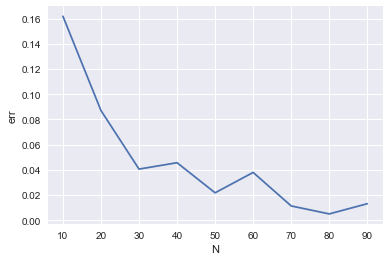

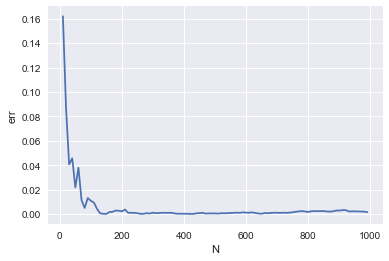

In [120]:
plt.plot(range(10, 100, 10), err[0: 9])
plt.xlabel("N")
plt.ylabel("err")
plt.show()
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

Из двух графиков выше очевидно, что уже при выборке больше 250 примеров различия становятся незаметными. Соответственно, ппри такой выборке обученная прямая регрессии будет визуально неотличима от настоящей прямой. При выборке меньше 250 точность будет ниже, так как при таком размере рандомно выбранные примеры не обязательно будут содержать ключевые признаки и, соответственно, корректно отображать зависимость.

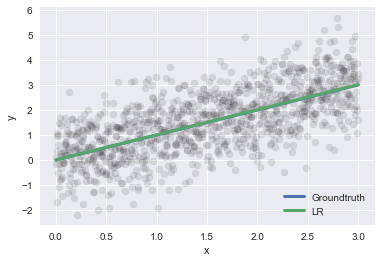

In [121]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = LRs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "LR"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()


Проделайте тоже самое для KNN при n_neighbors=3.

In [122]:
from sklearn.neighbors import KNeighborsRegressor
err = []
KNNs = []
for N in N_grid:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = N/1000, random_state = 2)
    clf = KNeighborsRegressor(n_neighbors=3, metric='euclidean')
    KNNs.append(clf.fit(X_train, y_train))
    err.append(np.mean(np.square((clf.predict(X) - y_gt))))

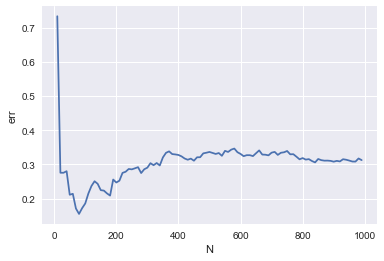

In [123]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

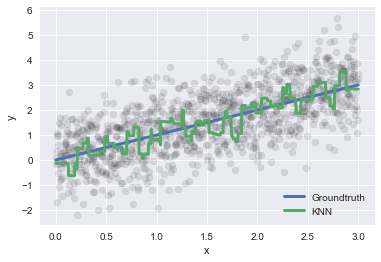

In [124]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = KNNs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Увеличте число соседей до 10 и проделайте тоже самое.

In [125]:
from sklearn.neighbors import KNeighborsRegressor
err = []
KNNs = []
for N in N_grid:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = N/1000, random_state = 2)
    clf = KNeighborsRegressor(n_neighbors=9, metric='euclidean')
    KNNs.append(clf.fit(X_train, y_train))
    err.append(np.mean(np.square((clf.predict(X) - y_gt))))

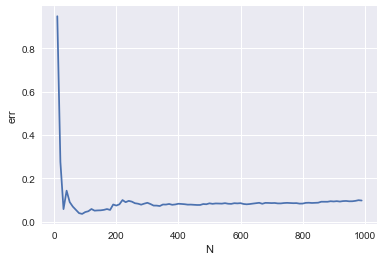

In [126]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

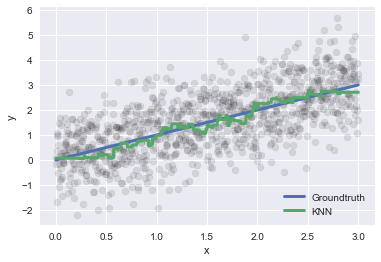

In [127]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = KNNs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Какие выводы можно сделать?

Можно сделать вывод лишь о том, что на данном датасете при учитывании его внутренней структуры большое количество соседей, например, 9 или 10, будет лучше отображать истинную зависимость. Видимо, при таком количестве соседей сформированная сформированная кривая будет близка к оптимальной.

#### Эксперимент 2

Изучим поведение регрессии с полиномиальными признаками. Для этого будем использовать класс PolynomialFeatures. Код вызова выглядит примерно так:

        import sklearn.preprocessing as pp
        pp.PolynomialFeatures(degree=d_new)
        X_new = pp.fit_transform(X)

Сгенерируйте выборку для $y = log \frac{1}{3} x + \epsilon$, где $x$ принимает значения из равномерной сетки на  [1, 10], $\epsilon \sim \mathcal{N}(0, 1)$. Рассмотрите три случая: линейный, полиномиальные признаки степени 2 и 5. Для каждого постройте графики, аналогичные графику из эксперимента 1 и сравните их. Какой эффект вы наблюдаете? По какой причине он возникакет? Постройте график истинной кривой, и наилучших среди полиномиальных, которые вы исследовали. Какая из них лучше всего приближает данные и почему?

In [128]:
import sklearn.preprocessing as pp

def f_target(X):
    return np.log(0.3*X)

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = np.arange(10, 1000, 10)
X, y, y_gt = gen_data(N_grid[-1], 1, 1, 10, f_target, f_noise)
y_gt = y_gt.reshape(990, 1)

Аналогично предыдущему пункту, обучите в трёх циклах три разные регрессии, сохраняя полученные ошибки и классы в списки err_i и LRs_i. Перед обучением второй и третьих моделей вам требуется преобразовать признаки в полиномиальные, используя указанный в примере класс PolynomialFeatures. Сохраните полученные признаки степени 2 в переменную X_new_2, а признаки степени 5 в переменную X_new_3. Обучение соответственно происходит на выборках (X, y), (X_new_2, y), (X_new_3, y).

In [129]:
err_1 = []
LRs_1 = []
for N in N_grid:
    pass
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size =  N/1000, random_state = 2)
    Lr = lm.LinearRegression()
    LRs_1.append(Lr.fit(X_train, y_train))
    err_1.append(np.mean(np.square((Lr.predict(X) - y_gt))))

err_2 = []
LRs_2 = []
pass
poly = pp.PolynomialFeatures(degree= 2)
X_new_2 = poly.fit_transform(X)[:, -1]
for N in N_grid:
    pass
    X_train, X_test, y_train, y_test = train_test_split(X_new_2.reshape(-1,1), y, train_size = N/1000)
    Lr = lm.LinearRegression()
    LRs_2.append(Lr.fit(X_train, y_train))
    err_2.append(np.mean(np.square(Lr.predict(X) - y_gt)))


err_3 = []
LRs_3 = []
pass # Преобразуйте признаки в полиномиальные степени 5
poly = pp.PolynomialFeatures(degree= 5)
X_new_5 = poly.fit_transform(X)[:, -1]
for N in N_grid:
    pass
    X_train, X_test, y_train, y_test = train_test_split(X_new_5.reshape(-1, 1), y, train_size = N/1000)
    Lr = lm.LinearRegression()
    LRs_3.append(Lr.fit(X_train, y_train))
    err_3.append(np.mean(np.square((Lr.predict(X) - y_gt))))


Код для построения всех графиков:

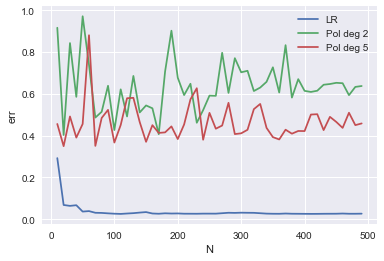

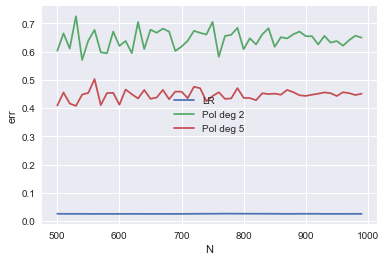

In [130]:
plt.plot(N_grid[:N_grid.size//2], err_1[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_2[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_3[:N_grid.size//2])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

plt.plot(N_grid[N_grid.size//2:], err_1[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_2[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_3[N_grid.size//2:])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

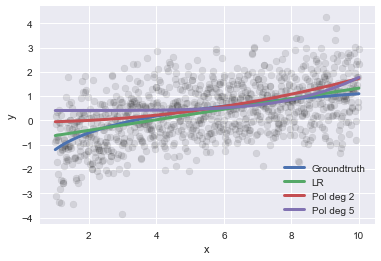

In [131]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred_1 = LRs_1[np.argmin(err_1)].predict(X)
plt.plot(X, y_pred_1, linewidth=3)
y_pred_2 = LRs_2[np.argmin(err_2)].predict(X_new_2.reshape(-1, 1))
plt.plot(X, y_pred_2, linewidth=3)
y_pred_3 = LRs_3[np.argmin(err_3)].predict(X_new_5.reshape(-1, 1))
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "LR", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

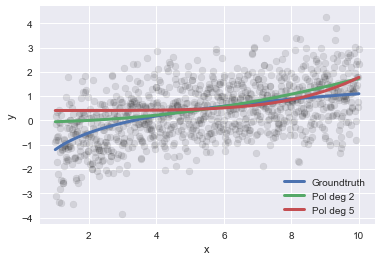

In [132]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred_2 = LRs_2[np.argmin(err_2)].predict(X_new_2.reshape(-1,1))
plt.plot(X, y_pred_2, linewidth=3)
y_pred_3 = LRs_3[np.argmin(err_3)].predict(X_new_5.reshape(-1, 1))
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Вообще, введение более сложных признаков призвано модифицировать линейную регрессию, чтобы придать ей нелинейность и дать возможность восстановления более сложных истинных зависимостей выборки. Однако из построенных графиков очевидно, что с ростом степеней признаков и, соответственно, их сложности, растёт и минимальный уровень ошибки, к которому стремится регрессия на больших выборках. Однако в данном эксперименте, как показывает вторая проловина графиков, линейная регрессия с данной задачей справляется лучше, и нет особого смысла в добавлении степенных признаков. Однако любопытно, что почти при всех размераз выборок средняя ошибка на степенях пять ниже, чем ошибка настепенях два, однако на последних графиках визуально кривая степеней пять меньше совпадает с кривой реальной зависимости, чем кривая степеней два.

#### Эксперимент 3

Рассмотрим данные с искусственно внесёнными в них линейными зависимостями. Для наглядности рассмотрим регрессию, которая фактически зависит лишь от одной переменной, но в сгенерированный набор данных внесём ещё несколько признаков, которые будут слабо коррелировать с первым.

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, $x$ принимает значения из равномерной сетки на [0, 3], $\epsilon \sim \mathcal{N}(0, 1)$. Добавьте в качестве второго признака $x_2 = 2x + \delta$, где $\delta \sim \mathcal{N}(0, 0.01)$, а в качестве третьего $x_3 = x_1 + x_2 + \nu$, где $\nu \sim \mathcal{N}(0, 0.25)$. Постройте графики истинной функции, линейной регрессии и Ridge регрессии, в зависимости от первого столбца данных (при этом саму регрессию нужно обучать по всем трём признакам). Какой эффект вы наблюдаете? Какая регрессия работает лучше и почему? (Для ответа на этот вопрос можете, например, сравнить веса признаков, полученные в случае обычной и Ridge линейных регрессий, параметр класса: coef_)

Пример вызова класса, выполняющего Ridge регрессию:

    Ridge = lm.Ridge()
    Ridge.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [263]:
def f_target(X):
    return X
def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация данных"""
N = 1000
X, y, y_gt = gen_data(N, 1, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.1, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.5, size=N).reshape((N, 1))
x2 = 2*X + delta
x3 = X + x2 + nu
X = np.concatenate([X, x2, x3], axis=1)

Аналогично предыдущим пунктам, обучите обычную и Ridge линейные регрессии на выборке (X, y) и получите предсказания для той и другой модели. Сохраните предсказания в переменные y_pred_LR и y_pred_Ridge.

In [264]:
pass
Lr = lm.LinearRegression()
Lr.fit(X, y)
y_pred_LR = Lr.predict(X)

Rr = lm.Ridge()
Rr.fit(X, y)
y_pred_Ridge = Rr.predict(X)

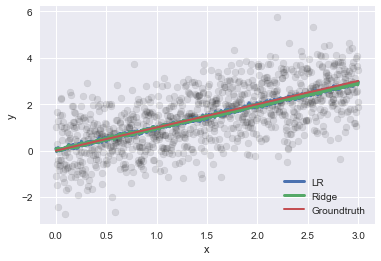

In [265]:
plt.scatter(X[:,0], y, c="black", alpha=0.1)
plt.plot(X[:,0], y_pred_LR, linewidth=3)
plt.plot(X[:,0], y_pred_Ridge, linewidth=3)
plt.plot(X[:,0], y_gt, linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

График для разности предсказанных ответов и истинных:

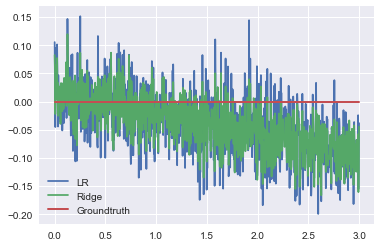

In [266]:
plt.plot(X[:,0], y_pred_LR - y_gt)
plt.plot(X[:,0], y_pred_Ridge - y_gt)
plt.plot(X[:,0], np.zeros(N), linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=3)
plt.show()

In [267]:
print(np.sum((y_pred_LR - y_gt)**2))
print(np.sum((y_pred_Ridge - y_gt)**2))

4.694720894748873
3.642354600322069


In [268]:
print(Lr.coef_)
print(Rr.coef_)

[[ 1.70304612 -0.26449601 -0.07061326]]
[[ 1.17920127 -0.01165675 -0.06492588]]


Очевидно, что Ridge-регрессия работает лучше, так как разница предсказанных и истинных ответов по всем примерам выборки ниже. Скорее всего, это происходит из-за элемента регуляризации гребневой регрессии веса ограничены и это не даёт слишком сильно выбиваться ответам на predict так же сильно, как при линейной регрессии.

#### Эксперимент 4

Рассмотрим последний предложенный вам вид регрессии: Lasso. Основным его свойством является возможность отбора признаков, в чём вам и придётся убедится. Сгенеририруйте двумерную выборку для зашумлённой функции $y = x_1 + x_2 + \epsilon$, $x_1$ и $x_2$ образуют равномерную линейную сетку на квадрате [0,1]x[0,1], $\epsilon \sim \mathcal{N}(0, 1)$, и добавьте в неё два линейно зависимых признака с шумом: 

$$x_3 = 2x_1 + \delta, \quad \delta \sim \mathcal{N}(0, 0.01)$$, 
$$x_4 = 0.5x_1 + x_2 + \nu, \quad \nu \sim \mathcal{N}(0, 0.25)$$ 

После этого запустите на данной выборке регрессию Ridge и Lasso, сравните получаемые веса для признаков. Какие эффекты вы наблюдаете? В чём различие? Как именно в Lasso производится явное уменьшение размерности данных?

Пример вызова класса, выполняющего регрессию Lasso:

    Lasso = lm.Lasso()
    Lasso.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [142]:
def f_target(X):
    return np.sum(X, axis=1).reshape((X.shape[0], 1))

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация выборки"""
n = 30
D = 2
N = n**D
X, y, y_gt = gen_data(n, D, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.1, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.5, size=N).reshape((N, 1))
x3 = 2*X[:,0].reshape((N, 1)) + delta
x4 = 0.5*X[:,0].reshape((N, 1)) + X[:,1].reshape((N, 1)) + nu
X = np.concatenate([X, x3, x4], axis=1)

Обучите на выборке регрессии Lasso и Ridge на выборке (X, y), используя вызовы соответствующих классов.

In [143]:
pass
Lasso = lm.Lasso()
Lasso.fit(X, y)

Ridge = lm.Ridge()
Ridge.fit(X, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [144]:
print(Lasso.coef_)
print(Ridge.coef_)

[0.         0.         0.16920725 0.05453173]
[[0.75957878 0.97217142 0.11046916 0.01429402]]


Ответ: Очевидно, что некоторые веса в Лассо-регрессии занулились. При этом веса Лассо-регрессии несколько больше, чем у гребневой по оставшимся признакам. Видимо, такой эффект наблюдается в результате повышения значимости конкретных признаков в Лассо-регрессии. Однако, возможно, этот эффект можно считать случайным.
При этом довольно странно, что исчезли именно веса признаков, которые были исходными.
Что касается принципа действия Лассо-регрессии, то если нарисовать в пространстве весов линии уровня функционала и ограничения, накладываемого регуляризатором, то будет очевидно, что решением будет являться ближайшая к глобальному минимуму функционала точка допустимого множества ограничений. Исходя из того, что ограничения задаются через модуль, нетрудно заметить, что всегда решение будет лежать на точке, где некоторые веса нулевые. (Например, вершина ромба в случае с двуммя весами модели)

## Часть 2. Задача с реальными данными

В данной части вам предлагается, используя изученные методы построения регрессии, проанализировать реальный датасет.

Будем исследовать данные по преступности в разных штатах США. От вас потребуется по большому количеству признаков, связанных с социальными и экономическими показателями, восстановить целевую переменную: среднее число преступлений на 100 тысяч человек. С полным описанием датасета можно ознакомиться здесь: https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime

In [434]:
import pandas as pd
import seaborn as sns; sns.set()

In [435]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data",
                   na_values="?", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


Исходя из описания датасета, первые 5 колонок не являются информативными признаками, убираем их.

In [436]:
data = data.iloc[:,5:]
data.head()

,5,6,7,8,9,10,11,12,13,14,...,118,119,120,121,122,123,124,125,126,127
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


#### 1. Вычислите и визуализируйте попарную корреляцию пирсона между всеми признаками.  Как коррелирующие признаки будут влиять на обучение линейной регрессии. Какие выводы можно сделать?

Для визуализации можно использовать seaborn.heatmap()

Ответ: Не очень понимаю, какой смысл визуализировать по всем признакам. Слишком неинформативный график получается. Разве что можно сказать, что какие-то признаки коррелируют друг с другом сильнее, какие-то слабее, но по идее, это волне очевидно и без графика. Коррелирующие признаки будут ухудшать качество прогноза модели, так как корреляция признаков не отражает то, что они оба будут существенны и характерны для предсказываемого значения, а лишь что они часто показывают одни и те же значения. Хотя и возможен результат, что это истинные ключевые признаки, он не является гарантированным. Следовательно, обучение на сильно коррелированных признаках будет повышать шанс ошибки на отдельных примерах.

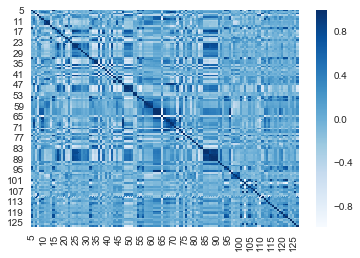

In [437]:
pass
correlation = data.corr(method = 'pearson')
sns.heatmap(correlation, cmap = "Blues")
plt.show()

#### 2. Найдите признаки у которых корреляция с предсказваемым значением максимальна и минимальна. Изобразите на графиках зависимость найденных признаков от предсказываемого значения.

0.7379565498586652 -0.7384238020704459
55    0.737957
Name: 127, dtype: float64
49   -0.738424
Name: 127, dtype: float64


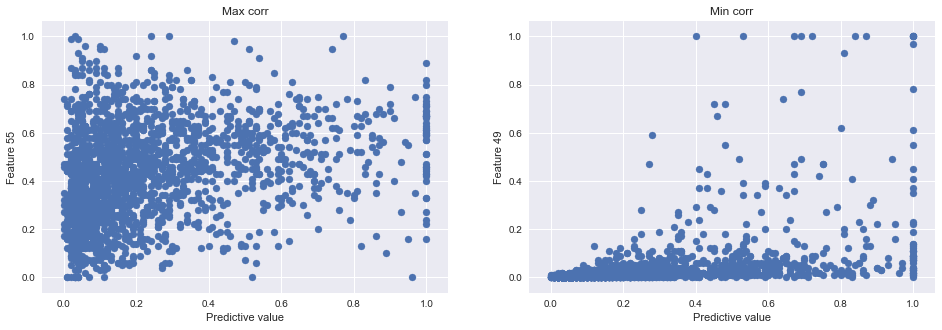

<function print>

In [438]:
pass
corr_goal = correlation.iloc[:-1, -1]
max_corr_goal = max(correlation.iloc[:-1, -1])
min_corr_goal = min(correlation.iloc[:-1, -1])
print(max_corr_goal, min_corr_goal)

print(corr_goal.loc[corr_goal == max_corr_goal])
print(corr_goal.loc[corr_goal == min_corr_goal])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (16, 5))

axes[0].scatter(data.iloc[:, -1], data.iloc[:, 55])
axes[0].set_title('Max corr')
axes[0].set_xlabel("Predictive value")
axes[0].set_ylabel("Feature 55")
axes[1].scatter(data.iloc[:, -1], data.iloc[:, 49])
axes[1].set_title('Min corr')
axes[1].set_xlabel("Predictive value")
axes[1].set_ylabel("Feature 49")
plt.show();
print


#### 3. Постройте гистограмму распределения предсказываемого значения.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


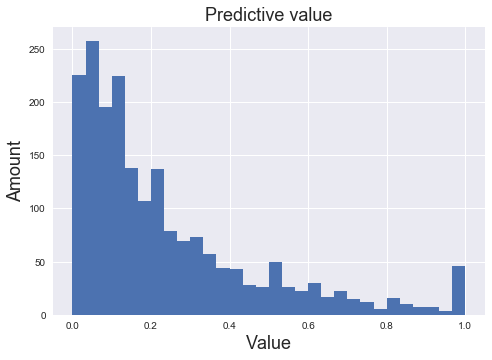

In [439]:
pass # Place your code here
fig = plt.figure()
axes1 = fig.add_axes([0.0, 0.0, 1.0, 1.0])
axes1.hist(data.iloc[:,-1].reshape(-1, 1), bins = 30)
axes1.set_title('Value')
axes1.set_xlabel('Value', fontsize=18)
axes1.set_ylabel('Amount', fontsize=18)
axes1.set_title('Predictive value', fontsize=18)
plt.show()


Как видно из заголовка датасета, в нём присутствует много пропущенных значений. Рассмотренные нами алгоритмы регрессии не содержат в себе методов обработки пропущенных значений, поэтому нам нужно избавиться от них на этапе предобработки данных.


#### 4. Замените все пропущенные значения на средние по соответствующим признакам. Сохраните результат в переменную data.

In [440]:
pass
for i in range(5, 128):
    data[i] = data[i].fillna(np.mean(data[i]))
print(data)

       5     6     7     8     9     10    11    12    13    14   ...    118  \
0     0.19  0.33  0.02  0.90  0.12  0.17  0.34  0.47  0.29  0.32  ...   0.12   
1     0.00  0.16  0.12  0.74  0.45  0.07  0.26  0.59  0.35  0.27  ...   0.02   
2     0.00  0.42  0.49  0.56  0.17  0.04  0.39  0.47  0.28  0.32  ...   0.01   
3     0.04  0.77  1.00  0.08  0.12  0.10  0.51  0.50  0.34  0.21  ...   0.02   
4     0.01  0.55  0.02  0.95  0.09  0.05  0.38  0.38  0.23  0.36  ...   0.04   
5     0.02  0.28  0.06  0.54  1.00  0.25  0.31  0.48  0.27  0.37  ...   0.01   
6     0.01  0.39  0.00  0.98  0.06  0.02  0.30  0.37  0.23  0.60  ...   0.05   
7     0.01  0.74  0.03  0.46  0.20  1.00  0.52  0.55  0.36  0.35  ...   0.01   
8     0.03  0.34  0.20  0.84  0.02  0.00  0.38  0.45  0.28  0.48  ...   0.04   
9     0.01  0.40  0.06  0.87  0.30  0.03  0.90  0.82  0.80  0.39  ...   0.00   
10    0.13  0.71  0.15  0.07  1.00  0.41  0.40  0.52  0.35  0.33  ...   0.02   
11    0.02  0.46  0.08  0.91  0.07  0.10

Разделим данные на три выборки: по одной мы будем обучать регрессию, по второй -- гиперпараметры, по третьей -- тестировать качество:

In [447]:
data = data.reindex(np.random.permutation(data.index))
data_train, data_validate, data_test = np.array_split(data, 3)

Учтём, что целевая переменная -- это последний столбец данных:

In [448]:
X_train = data_train.iloc[:,:-1]
y_train = data_train.iloc[:,-1]
X_validate = data_validate.iloc[:,:-1]
y_validate = data_validate.iloc[:,-1]
X_test = data_test.iloc[:,:-1]
y_test = data_test.iloc[:,-1]

In [449]:
X_train_new = np.concatenate([X_train, X_validate], axis=0)
y_train_new = np.concatenate([y_train, y_validate], axis=0)

#### 5. Обучите обычную линейную регрессию на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

Качество оценивайте, как среднеквадратичное отклонения ваших предсказаний на тестовой выборке от истинных значений: $$\text{err}\ (y^{pred}, y^{test}) = \frac{1}{N} \sum_{n=1}^N (y^{pred}_n - y^{test}_n)^2$$

In [450]:
pass # Place your code here

Lr = lm.LinearRegression()
Lr.fit(X_train_new, y_train_new)
y_predict = Lr.predict(X_test)
err = np.mean(np.square(y_predict - y_test))
print("Ошибка линейной регрессии:", err)


Ошибка линейной регрессии: 0.02124838622226268


#### 6. Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения гиперпараметра alpha для  регрессий Ridge и Lasso

In [451]:
pass # Place your code here
from sklearn.model_selection import GridSearchCV
Ridge = lm.Ridge()
Lasso = lm.Lasso()
params = {'alpha': [0.01, 0.1, 0.5, 1, 2, 3, 4 ,5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}
Ridge.get_params().keys()
gr_Ridge = GridSearchCV(estimator = Ridge, param_grid = params, cv = 5, scoring = "neg_mean_squared_error")
gr_Lasso = GridSearchCV(estimator = Lasso, param_grid = params, cv = 5, scoring = "neg_mean_squared_error")
gr_Ridge.fit(X_validate, y_validate)
gr_Lasso.fit(X_validate, y_validate)
print("Лучший параметр Ridge:", (gr_Ridge.best_params_)["alpha"])
print("Лучший параметр Лассо:", (gr_Lasso.best_params_)['alpha'])

Лучший параметр Ridge: 4
Лучший параметр Лассо: 0.01


Так как функция, которая перемешивает выборку, каждый раз перемешивает её по-разному и из-за этого каждый раз параметр альфа для гребневой регрессии получается разный даже при фиксированном количестве шагов кросс-валидации, я предлагаю поверить мне на слово, что я эмпирически подобрал подобрал для гребневой альфа равное 4, а при Лассо-регрессии он во всех экспериментах стремился к нулю, и подобрать невозможно более точно, так как функция ругается на то, что алгоритм не сходится. Поэтому я привожу значение альфа для гребневой - 4, а для Лассо - более-менее адекватное 0.01. Далее обучение будет на них.

Рассмотрите значения полученных весов для регрессии в с лучшим alpha для Ridge и Lasso. В чём их существенная разница? Какие выводы вы можете сделать о структуре данных по регрессионным весам?

In [452]:
Ridge_best = lm.Ridge(alpha = (gr_Ridge.best_params_)["alpha"])
Ridge_best.fit(X_train_new, y_train_new)
print(Ridge_best.coef_)

Lasso_best = lm.Lasso(alpha = (gr_Lasso.best_params_)["alpha"])
Lasso_best.fit(X_train_new, y_train_new)
print(Lasso_best.coef_)

[-0.01749153  0.02721231  0.14824303 -0.05764512 -0.0390368   0.01305863
 -0.00811065 -0.06656534 -0.01098042  0.03845506 -0.01524626  0.04555295
  0.01268161 -0.04002306  0.02299967 -0.10428048  0.0053321   0.06855348
 -0.06699537 -0.01325579 -0.00641582 -0.04631383 -0.01979464 -0.01491439
  0.05171021  0.05005193  0.01151916 -0.01293011 -0.09057129 -0.05375776
  0.02729756  0.00138232  0.00680872  0.05144533 -0.05080965 -0.04458868
  0.01046476  0.00861618  0.07456946  0.06457894 -0.02146818  0.01869747
  0.03077957 -0.0738792  -0.07859191 -0.08206414 -0.05346343  0.00498516
 -0.08104466 -0.01025692  0.16285797 -0.02678181  0.06578912 -0.00875624
 -0.05415508  0.01157182  0.00371067  0.02345255  0.0305187   0.0183074
 -0.01267949 -0.0590706  -0.02688674 -0.01758664  0.06546864 -0.04471693
 -0.0134696  -0.01761616  0.06889466  0.03019626  0.0039341   0.10505168
 -0.07447246  0.03239854  0.05737069 -0.05305446 -0.00658508  0.01772812
 -0.01897032 -0.02461265 -0.0049587   0.02103632 -0.

Ответ: Результат показывает, что большинство признаков были признаны Лассо-регрессией несущественными и были отброшены. Что интересно, ниже будет приведён список индексов трёх признаков, которые остались в Лассо, и два из трёх - те самые максимально и минимально коррелированные с предсказываемым значением признаки! Это означает, что в структуре данных есть несколько скоррелированных с предсказываемым значением признаков, которые достаточно хорошо отображают реальную зависимость, а остальные - относительно малоинформативны.
Ниже на этих признаках обуччены модели, не хочу разбивать ячейку ответа. Ошибка гребневой регрессии несколько увеличилась, что, видимо, связано с попыткой ограничить веса, которая была не особо нужна в данном случае. Ошибка Лассо-регрессии увечилилась заметнее. Скорее всего, это означает, что при отбросе признаков в предыдущем пункте, некоторые относительно важные признаки были отброшены напрасно. Отвечая, насколько сильно увеличилась ошибка, можно, конечно, посчитать разницу, но проблема MSE в том, что её проблематично интерпретировать и сложно сказать, будет эта разница существенной или нет.

Исходя из весов регрессии Lasso, отберите наиболее релевантные признаки и обучите две лучшие регрессионные модели только на них. Насколько сильно при этом изменилась средняя ошибка? Что это говорит о структуре данных? 

In [453]:
pass
X_Lasso = pd.DataFrame()
k = 0
new_features = []
for i in range(len(Lasso_best.coef_)):
    if Lasso_best.coef_[i] != 0:
        X_Lasso.loc[:, k] = data.loc[:, i+5]
        new_features.append(i+5)
        k = k + 1
y_Lasso = data.iloc[:, -1]

Ridge_Regression_best = lm.Ridge(alpha = (gr_Ridge.best_params_)["alpha"])
Ridge_Regression_best.fit(X_Lasso, y_Lasso)
Ridge_best_predict = Ridge_Regression_best.predict(X_Lasso)
MSE_Ridge_best = mean_squared_error(Ridge_best_predict, y_Lasso)
print('MSE Ridge:' + str(MSE_Ridge_best))

Lasso_Regression_best = lm.Lasso(alpha = (gr_Lasso.best_params_)["alpha"])
Lasso_Regression_best.fit(X_Lasso, y_Lasso)
Lasso_best_predict = Lasso_Regression_best.predict(X_Lasso)
MSE_Lasso_best = mean_squared_error(Lasso_best_predict, y_Lasso)
print("MSE Lasso:" + str(MSE_Lasso_best))
print(new_features)



MSE Ridge:0.021402410881046573
MSE Lasso:0.023833269197941414
[8, 49, 55]


#### 7. Обучите KNN на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

In [454]:
pass
clf_new = KNeighborsRegressor(metric = 'minkowski')
clf_new.fit(X_train_new, y_train_new)
KNN_predict = clf_new.predict(X_test)
MSE_KNN = mean_squared_error(KNN_predict, y_test)
print(MSE_KNN)

0.02033993373493976


#### 8. Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения параметров n_neighbors и p при выборе  metric='minkowski'

In [455]:
pass
print(list(np.arange(1, 15)))

params = {'n_neighbors': list(np.arange(7, 13)), 'p': list(np.arange(1, 2))}
clf_new.get_params().keys()
gr_clf_new = GridSearchCV(estimator = clf_new, param_grid = params, cv = 5)

gr_clf_new.fit(X_train_new, y_train_new)
print((gr_clf_new.best_params_))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
{'n_neighbors': 12, 'p': 1}


Я не выставлял большую разницу на параметре "p" так как я пробовал на промежутке от 1 до 10 и после получаса перебора получил всё ту же единицу. Поэтому в рабочей версии кода перебирается в основном количество соседей для экономии времени.

С помощью какого алгоритма удалось достичь лучшего качества?

In [456]:
clf_new = KNeighborsRegressor(metric = 'minkowski', p = gr_clf_new.best_params_['p'], n_neighbors = gr_clf_new.best_params_['n_neighbors'])
clf_new.fit(X_train_new, y_train_new)
KNN_predict = clf_new.predict(X_test)
MSE_KNN = mean_squared_error(KNN_predict, y_test)
print(MSE_KNN)

0.019661167587014725


Хотя различия и кажутся малозаметными, так как их сложно интерпретировать, победу одерживает KNN регрессия

Напишите отчёт по исследованному вами датасету. Какими он обладает ключевыми свойствами? Какие методы вам пришлось использовать, чтобы его исследовать? Что вы можете сказать об информативности используемых в нём признаков? Какой из опробованных методов вы бы предпочли использовать на нём и почему?

Ответ: 
Ключевые свойства данного датасета - большое количество признаков, которые не оказывали существенного влияния на работу модели. Вероятнее всего, это были признаки, чья корреляция с предсказываемым значением была ближе к нулю. При этом, исходя из гистограммы распределения предсказываемого значения, можно заметить, что этот признак чаще находится в районе нуля, чем ближе к единице.
Было использовано несколько методов. Например, нахождение корреляции и построение корреляционной таблицы. Также была построена гистограмма распределения и графики наиболее и наименее коррелированных признаков. Также были использованы методы регуляризации, позволяющие избежать переобучения модели или отобрать наиболее релевантные признаки. Помимо этого для оптимизации модели были применены функции подбора параметров регрессии, которые позволяли повысить точность без внесения существенных изменений в код. Ещё были использованы разные типы регрессий, каждая из которых давала разные результаты.
Информативность признаков. После проведённых исследований можно сказать, что большинство признаков оказывают мало влияния на  процесс восстановления исходной зависимости и при правильном подборе метода оптимизации могут быть успешно отброшены из анализа.
На данном датасете я бы предпочёл использовать Ridge-регрессию, так как при его небольших размерах, выигрыш от экономии времени исполнения кода и сохранения памяти несущественен, а точность всё же падает. Или же можно было бы использовать обычную линейную регрессию, так как она максимально проста в использовании и к тому же показала наиболее качественный результат на тестах. Ну и конечно, использовался бы GridSearch за простоту и большую практическую ценность.

### Бонусная часть

За выполнение указанного ниже задания вам могут быть начислены дополнительные баллы свыше максимальных 10.

##### Реализуйте свмостоятельно функцию, которая будет перебирать значения гиперпараметра по линейной сетке 

Процесс обучения модели будет состоять из двух этапов.

Сначала для каждого значения гиперпараметра из заранее заданной сетки мы обучим регрессию на выборке (X_train, y_train) и проверим качество её работы на выборке (X_validate, y_validate). Сохранив полученные значения, среди всех перебранных значений гиперпараметра выберем такое, на котором достигается наименьшая ошибка на выборке (X_validate, y_validate).

После этого мы фиксируем значение гиперпараметра, и обучаем итоговый алгоритм на выборке, полученной объединением из X_train и X_validate . Тем самым мы сможем добиться лучшей настройки параметров регресси.

В конце концов, для тестирования качества работы нашей модели, мы проверяем её на тестовой выборке (X_test, y_test). Ошибка на этой выборке позволяет нам судить об обобщающей способности нашей модели, т.к. она не участвовала ни в одном этапе обучения. Обобщающая способность -- оценка того, насколько хорошо модель регрессии будет работать на новых данных.

In [418]:
def optimizer(X_train, y_train, X_validate, y_validate, 
              alpha_min, alpha_max, RegressionClass):
    alpha_grid = np.linspace(alpha_min, alpha_max, 100)
    err = []
    for alpha in alpha_grid:
        Regressor = RegressionClass(alpha = alpha)
        Regressor.fit(X_train, y_train)
        err.append(mean_squared_error(Regressor.predict(X_validate), y_validate ))
        min_err = min(err)
        index = err.index(min_err)
        alpha = alpha_grid[index]
    #alpha_grid - массив перебираемых значений гиперпараметра
    #alpha - найденное оптимальное значение гиперпараметра 
    #err - массив среднеквадратичных отклонений для каждого из alpha_grid
    
    return alpha, err, alpha_grid

Пример вызова:
        
        alpha, err, alpha_grid = optimiser(X_train, y_train, 
                                           X_validate, y_validate,
                                           alpha_min, alpha_max,
                                           lm.Ridge)

От вас требуется применить линейную регрессию, а также Ridge и Lasso регрессию, получив оптимальные значения для alpha при помощи функции optimizer, и сравнить полученные среднеквадратичные отклонения ваших предсказаний на тестовой выборке от истинных значений: $$\text{err}\ (y^{pred}, y^{test}) = \frac{1}{N} \sum_{n=1}^N (y^{pred}_n - y^{test}_n)^2$$

Для того чтобы понять, какие значения alpha для регрессий Ridge и Lasso являются оптимальными, вам нужно подобрать параметры alpha_min и alpha_max так, чтобы на графиках зависимости ошибки err от alpha был виден отчётливый минимум. Код для построения графиков указан ниже.

Обучите регрессии на выборке (X_train_new, y_train_new)
Какая из трёх регрессий работает лучше? Какая хуже? Почему?

Сделайте вызов функции optimizer для Ridge регрессии на выборках (X_train, y_train), (X_validate, y_validate), воспользовавшись примером её запуска. Получите оптимальное alpha, подобрав параметры alpha_min, alpha_max, как указано в задании. Обучите регрессию на выборке (X_train_new, y_train_new) с полученным параметром alpha, который передаётся при инициализации класса, например:

    lm.Ridge(alpha=my_alpha)
    
и сохраните ответы на тестовой выборке X_test в переменную y_pred

In [419]:
pass # Place your code here
#Ridge regression

alpha_Ridge, err_Ridge, alpha_grid = optimizer(X_train, y_train, X_validate, y_validate, 5, 25, lm.Ridge)
Ridge = lm.Ridge(alpha = alpha_Ridge)
Ridge.fit(X_train_new, y_train_new)
y_pred = Ridge.predict(X_test)
print(np.mean((y_pred - y_test)**2))
#print(data.mean()[-1]) Я так и не понял, зачем тут нужна эта строчка

0.019617636560102864


Код для построения графиков ошибки на валидационной выборке в зависимости от alpha:

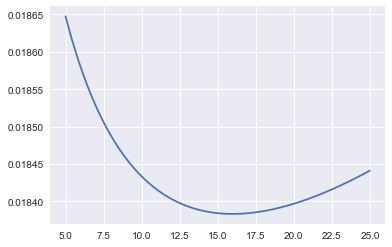

In [420]:

plt.plot(alpha_grid, err_Ridge)
plt.show()

Аналогично части задания для регресии Ridge, сделайте вызов функции optimizer для регрессии Lasso, обучите её с оптимальным alpha на выборке (X_train_new, y_train_new) и сохраните предсказания для X_test в y_pred

In [421]:
pass # Place your code here
alpha_Lasso, err_Lasso, alpha_grid = optimizer(X_train, y_train, X_validate, y_validate, 0.0001, 0.01, lm.Lasso)
Lasso = lm.Lasso(alpha = alpha_Lasso)
Lasso.fit(X_train_new, y_train_new)
y_pred = Lasso.predict(X_test)
print(np.mean((y_pred - y_test)**2))
#print(data.mean()[-1])

0.019459103397931006


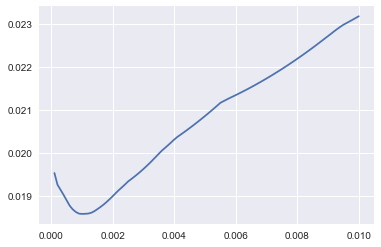

In [422]:
plt.plot(alpha_grid, err_Lasso)
plt.show()

#### Бонусная часть 2

Ещё одним способом построения новых признаков по выборке (помимо полиномиальных преобразований) являются так называемые приближения ядер RBF (Radial Basis Function Kernel Approximations). Данный метод используется широко и везде, так как позволяет проводить в данных регрессионные кривые, вообще говоря, практически произвольной сложности. Суть его заключается в том, что он производит некоторое нелинейное преобразование признаков, которое призвано приближать абстрактное пространство бесконечной размерности. Если размерность пространства бесконечна, то в нём можно посредством линейной регрессии провести произвольную разделяющую поверхность -- в этом суть мощности данного метода.

У метода существуют два настраиваемых параметра: gamma и n_components. Для объяснения значения первого параметра потребуется подключать достаточно сложную линейную алгебру или привлекать понятие ядровой функции, что мы делать сейчас не будем. Смысл второго параметра -- количество получаемых признаков. Т.к. пространство, которое мы пытаемся приблизить, бесконечной размерности, то, вообще говоря, в n_components можно поставить любое число. Чем больше оно будет, тем лучше наши новые данные будут приближать абстрактное пространство. Данные параметры в любом случае следует лишь перебирать по сетке и выбирать те, на которых меньше всего ошибка. Для того чтобы перебор не оказался слишком большим, положим n_components равным размеру выборки, и будем настраивать лишь gamma. В предложенной задаче это не критично.

Ниже приведён код, который уже знакомым вам по функции optimizer образом переберёт по сетке гиперпараметры используемых методов: параметр gamma для RBF, и параметр alpha для Ridge регрессии. Перебор будем осуществлять по всем возможным комбинациям gamma и alpha, выбрав комбинацию с наименьшей ошибкой на валидационной выборке. Обратите внимание, что обучаться мы будем именно по подвыборке признаков, полученных вами в предыдущем задании, т.е. исключая из данных большую часть данных. Интересно, что из этого выйдет?

In [358]:
X_train_shrinked = X_train.iloc[:,new_features]
X_validate_shrinked = X_validate.iloc[:,new_features]
X_test_shrinked = X_test.iloc[:,new_features]
X_train_new_shrinked = X_train_new[:,new_features]
?X_test_shrinked

In [359]:
from sklearn import kernel_approximation as ka

alpha_grid = np.linspace(0.001, 1, 10)
gamma_grid = np.linspace(0.001, 1, 10)

min_err = +np.inf
for alpha in alpha_grid:
    for gamma in gamma_grid:
        RBF = ka.RBFSampler(gamma=gamma, n_components=X_train.shape[0])
        X_train_rbf = RBF.fit_transform(X_train_shrinked)
        X_validate_rbf = RBF.transform(X_validate_shrinked)
        Ridge = lm.Ridge(alpha=alpha)
        Ridge.fit(X_train_rbf, y_train)
        y_pred = Ridge.predict(X_validate_rbf)
        err = np.mean((y_pred - y_validate)**2)
        if err < min_err:
            min_err = err
            alpha_best = alpha
            gamma_best = gamma
print(alpha_best)
print(gamma_best)

0.001
1.0


Выполнив код выше, вы получили две переменные alpha_best и gamma_best с оптимальными значениями гиперпараметров. От вас потребуется обучить на выборке (X_train_new_shrinked, y_train_new) преобразование RBF с параметром gamma_best (параметр n_components заполните так, как указано в примере ниже), а потом обучить на полученных признаках Ridge регрессию с полученным alpha_best и сравнить получившуюся ошибку с ошибой всех предыдущих методов. Какой эффект вы заметили?

Для обучения преобразования RBF вам потребуется сначала преобразовать обучающую выборку с помощью метода fit_transform (в вашем случае X_train_new_shrinked), а потом применить обученное преобразование к тестовой выборке (X_test_shrinked)

    RBF = ka.RBFSampler(gamma=gamma_best, n_components=X_train_new.shape[0])
    X_train = RBF.fit_transform(X_train)
    X_test = RBF.transform(X_test)

Ниже запишите вызов класса RBF, получите новые признаки для обучающей и тестовой выборки. Постройте Ridge регрессию по выборке (X_train_new_shrinked, y_train_new), найде предсказания для тестовой X_test_shrinked, поместите их в переменную y_pred.

Ответ: Какая-то проблема с кодом. Первый пример хоть как-то работает, зоть и с повышенной ошибкой, но как заставить работать то, что во втором примере кода я не знаю.

In [432]:
pass
RBF = ka.RBFSampler(gamma=gamma_best, n_components=X_train_new.shape[0])
X_train = RBF.fit_transform(X_train)
X_test = RBF.transform(X_test)

Ridge_RBF = lm.Ridge(alpha = alpha_best)
Ridge_RBF.fit(X_train, y_train)
print(X_test_shrinked)
y_pred = Ridge_RBF.predict(X_test)
print(np.mean((y_pred - y_test)**2))
#print(data.mean()[-1])

[[ 0.01621041 -0.03426872 -0.01083601 ...  0.00462537 -0.03742941
   0.01134565]
 [ 0.00325367 -0.0366345  -0.03130013 ...  0.01881405 -0.03681516
   0.01828187]
 [ 0.02078502 -0.02920638  0.00151515 ... -0.002061   -0.03690615
   0.01148234]
 ...
 [ 0.02162429 -0.02474867  0.00400832 ... -0.00163454 -0.03877686
   0.01595866]
 [ 0.02849902 -0.022193    0.01776232 ... -0.00487818 -0.03813454
   0.01563721]
 [ 0.03843281  0.01007592  0.00830397 ...  0.00716077  0.01167347
  -0.02798597]]
0.1107205772806886


In [363]:
pass
print(X_test_shrinked)
RBF = ka.RBFSampler(gamma=gamma_best, n_components=X_train_new_shrinked.shape[0])
X_train_shrinked = RBF.fit_transform(X_train_shrinked)
X_test_shrinked = RBF.transform(X_test_shrinked).reshape(664, -1)

Ridge_RBF = lm.Ridge(alpha = alpha_best)
Ridge_RBF.fit(X_train_new_shrinked, y_train_new)
print(X_test_shrinked)
y_pred = Ridge_RBF.predict(X_test_shrinked.reshape(664, -1))
#print(np.mean((y_pred - y_test)**2))
#print(data.mean()[-1])

[[ 0.00983076 -0.03760485 -0.03838355 ...  0.0387723  -0.03456879
  -0.01693193]
 [-0.0032062  -0.02684549 -0.02862634 ...  0.03877794 -0.03482127
  -0.00803154]
 [ 0.00735894 -0.03864582 -0.03859903 ...  0.03827382 -0.03559907
  -0.02387996]
 ...
 [-0.00192718 -0.03837596 -0.03877833 ...  0.03730956 -0.03830084
  -0.02823445]
 [ 0.00222344 -0.03861329 -0.0369413  ...  0.03692179 -0.03800926
  -0.03208292]
 [-0.00834745 -0.03420562 -0.03649811 ...  0.03504895 -0.02026202
  -0.03325364]]
[[ 0.01621041 -0.03426872 -0.01083601 ...  0.00462537 -0.03742941
   0.01134565]
 [ 0.00325367 -0.0366345  -0.03130013 ...  0.01881405 -0.03681516
   0.01828187]
 [ 0.02078502 -0.02920638  0.00151515 ... -0.002061   -0.03690615
   0.01148234]
 ...
 [ 0.02162429 -0.02474867  0.00400832 ... -0.00163454 -0.03877686
   0.01595866]
 [ 0.02849902 -0.022193    0.01776232 ... -0.00487818 -0.03813454
   0.01563721]
 [ 0.03843281  0.01007592  0.00830397 ...  0.00716077  0.01167347
  -0.02798597]]


ValueError: shapes (664,1330) and (3,) not aligned: 1330 (dim 1) != 3 (dim 0)